# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import glob 
import cv2
import numpy as np
import skimage
import matplotlib.image as mpimg
from skimage import data, color, exposure
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import matplotlib.pylab as plt
import scipy
import imutils
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
keras.backend.set_image_dim_ordering('th')
from utils import Box, yolo_boxes, draw_box
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.


### Credits:
Darknet.keras : https://github.com/sunshineatnoon/Darknet.keras

In [2]:

cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

# make ground truth
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])
# read X
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


In [4]:
#load testing picture

TEST_IMG_RBG = mpimg.imread(cars[4])
TEST_IMG_G = cv2.cvtColor(TEST_IMG_RBG, cv2.COLOR_RGB2GRAY)

TEST_FULL_IMG = mpimg.imread("./test_images/test1.jpg")

## 1. Histogram of Oriented Gradients (HOG)
#### 1.1.1 Explain how (and identify where in your code) you extracted HOG features from the training images. 

In [5]:
def process_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#### 1.1.2 Explain how you settled on your final choice of HOG parameters.

In [6]:
orient = 9
pix_per_cell = 4
cell_per_block = 2

In [7]:
# Call our function with vis=True to see an image output
features, hog_image = process_hog_features(TEST_IMG_G, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

In [8]:
# Call our function with vis=True to see an image output
features = process_hog_features(TEST_IMG_G, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

In [9]:
features.shape

(15, 15, 2, 2, 9)

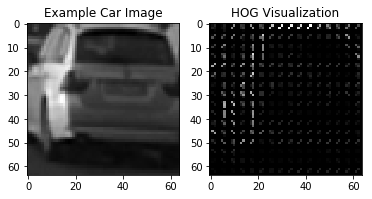

In [10]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(TEST_IMG_G, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## 2. Vehicle Detection and Tracking

In [11]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [12]:
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])

load_weights(model,'./yolo-tiny.weights')

In [13]:
image = plt.imread('./test_images/test1.jpg')
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [14]:
batch = np.transpose(resized,(2,0,1))
batch = np.array([((batch/255.) - 0.5)])
out = model.predict(batch)
boxes = yolo_boxes(out[0], threshold = 0.15)

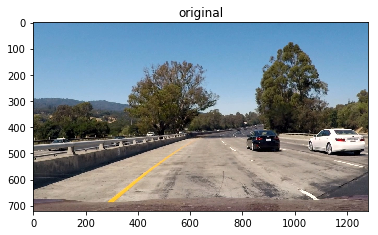

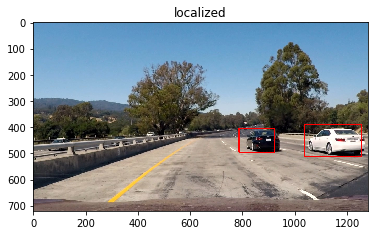

In [15]:
plt.figure()
plt.title("original")
plt.imshow(image)
plt.figure()
plt.title("localized")
plt.imshow(draw_box(boxes,plt.imread("./test_images/test1.jpg"),[[500,1280],[300,650]]))

#### Sliding window search

Since YOLO will output the 7X7X30 result, loop through the gird can get the prediction result. 
The model will return two type result, Class probability map and Bounding Box & confidence

probability map:  is a map of prob. of which class belongs with. 7X7X20 <~ 20 classes
BBOX, confidence: is the prediction of classes 7X7X(2*5)

####  How did you decide what scales to search and how much to overlap windows?
I combine the BBOX with IOU larger than 0.4. 
```
    boxes.sort(key=lambda b:b.prob,reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0: continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if box_iou(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]
```

#### Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

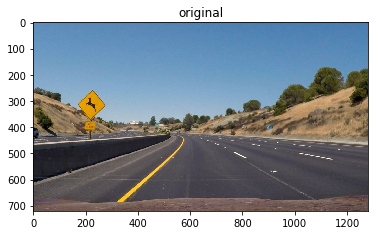

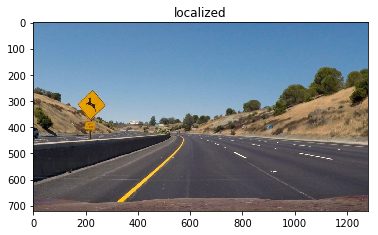

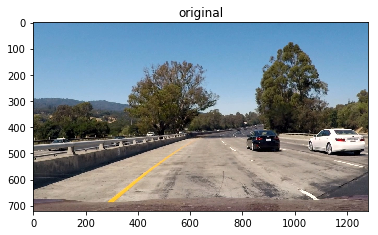

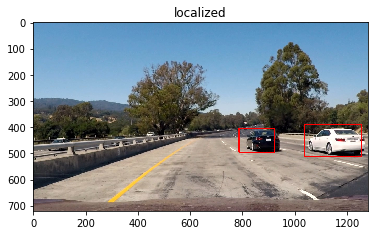

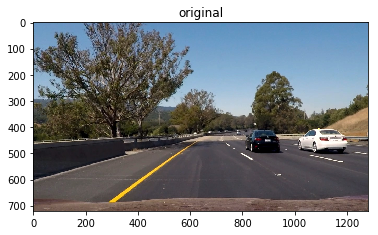

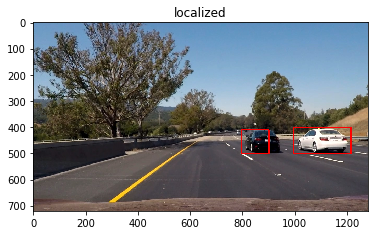

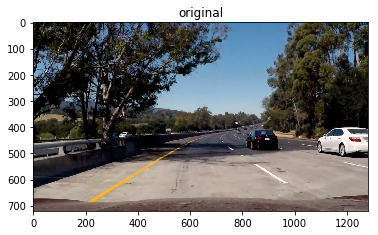

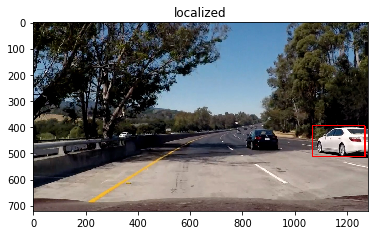

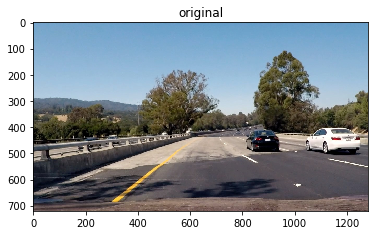

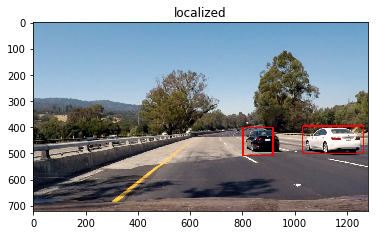

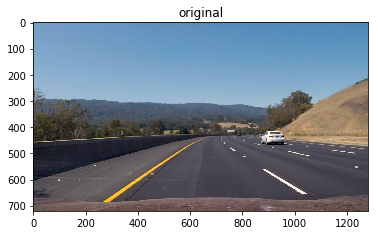

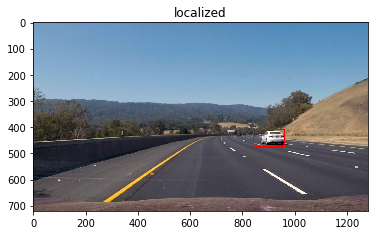

In [16]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
out = model.predict(((batch/255.)-0.5))

for i in range(len(batch)):
    plt.figure()
    plt.title("original")   
    plt.imshow(images[i]) 
    plt.figure()
    plt.title("localized")    
    boxes = yolo_boxes(out[i], threshold = 0.17)
    plt.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))
    plt.savefig("./output_images/"+str(i)+".png")

## 3. Video Implementation
#### 3.1 Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

#### Define pipeline

In [17]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    out = model.predict(np.array( [ ( (batch/255.)-0.5) ] ))
    boxes = yolo_boxes(out[0], threshold = 0.15)
    return draw_box(boxes,image,[[500,1280],[300,650]])

def process_video(source_file_name, output_file_name):
    white_output = output_file_name
    clip1 = VideoFileClip(source_file_name)
    white_clip = clip1.fl_image(frame_func)
    %time white_clip.write_videofile(white_output, audio=False)

In [18]:
process_video( "test_video.mp4", "test_video_out.mp4")
HTML("""
    <video controls src="{0}" loop=1 autoplay width=100%/> 
    """.format('test_video_out.mp4')
)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min 10s, sys: 4.63 s, total: 2min 14s
Wall time: 20.1 s


In [19]:
process_video( "project_video.mp4", "project_video_out.mp4")
HTML("""
    <video controls src="{0}" loop=1 autoplay width=100%/> 
    """.format('project_video_out.mp4')
)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [11:48<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 12min 24s, sys: 2min 38s, total: 1h 15min 2s
Wall time: 11min 48s


## 3. Discussion
#### 3.1 Briefly discuss any problems / issues you faced in your implementation of this project. 

I have try to implement Faster RCNN for object localization, but iy seems have problem in training. Thus i use pre-train YOLO for faster implemenation.

The main challenge of training a network to predict the bounding box. The network implementation is the hardest challenage in my faster rcnn implementation, it have to implement rpn and roi layer, too much moving parts. YOLO have a simple structure to localize the bounding box. Although i think Faster RCNN structure can be more stable then YOLO, but YOLO is easier to implement with pre-train weights.

#### 3.2 Where will your pipeline likely fail?

- Samll target object
    Yolo using 7X7 feature grid to predict object prosition which loose many deatils of target object. The network will miss those data.
- Vibrating BBOX
    The bbox keep vibrate through the video
- BBox size are not prefect. 
    Since the network is single flow architecture, which do not have other sub- network for refine BBOX position. YOLO architecture show the weakness of predict a full size of target object, for instance the black car in testing video. The BBox predict by YOLOnot always full cover the black car.  

#### 3.3 What could you do to make it more robust?

- Implement Faster RCNN
    It provide a more stable solution on predict the bounding box, ot use rpn network to predict the BBOX and then push to Roi pooling layer for other work. There are a new paper Masked RCNN, which extend Faster RCNN and provide image segmentation. Faster RCNN architecture have a better potential to implement different problem. 